# Marker gene database maker
The purpose of this jupyter notebook is to run through a workflow of creating a blast database containing protein sequences of a given gene from a wide range of taxonomic groups that can be used to validate newly submitted sequences against. 

Broadly, this process involves the following steps: 

1. Starting with an Entrez query for the Gene database, download sequences and metadata for genes, transcripts and proteins using NCBI Datasets
2. Parse the data archive from step 1 to tabulate names and symbols for review
3. Parse the data archive from step 1 to tabulate variability in the sequence lengths for review 
4. Given a set of taxonomic group identifiers, tabulate the number of sequences for each group that are present in the data archive
5. Extract sequences from each taxonomic node and generate all-vs-all BLAST alignments 
6. Review the BLAST tabular output to make a list of accessions that are outliers or incorrect that need to be removed from the final BLAST database 
7. Generate a final BLAST database that can be used with VADR and other tools for validating newly submitted sequences.

## Download data

Sequence and metadata are downloaded using NCBI Datasets using an Entrez query provided by the user. 

In [1]:
import Bio
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
import sys
import seaborn as sns
import numpy as np

/home/mcveigh/.local/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
## specify Entrez query and output filename. 
# Toogle between query options for a search vs. an accession list
entrez_query = 'arthropoda [ORGN] AND cytb [GENE] AND source mitochondrion [PROP] NOT rnatype mrna [PROP] NOT srcdb pdb [PROP] NOT uncultured NOT unverified NOT TPA'
#list = open("acclist_tosearch", "r")
#entrez_query = " ".join(list)
#print(entrez_query)
email = 'mcveigh@ncbi.nlm.nih.gov'
output_file = 'ncbi_dataset.zip'

In [5]:
import scripts.obtain_gene_datasets as dl

gene_ids_file = 'gene_ids.txt'
dl.populate_gene_ids_file(entrez_query, email, gene_ids_file)
json_data = dl.format_file_data_into_json(gene_ids_file)
dl.obtain_gene_datasets(json_data, output_file)

Gene search for query 'arthropoda [ORGN] AND cytb [GENE] AND source mitochondrion [PROP] NOT rnatype mrna [PROP] NOT srcdb pdb [PROP] NOT uncultured NOT unverified NOT TPA' returned 2923 results


## Unzip Datasets archive

In [3]:
!unzip -o {output_file}

Archive:  ncbi_dataset.zip
  inflating: README.md               
  inflating: ncbi_dataset/data/protein.faa  
  inflating: ncbi_dataset/data/data_report.jsonl  
  inflating: ncbi_dataset/data/data_table.tsv  
  inflating: ncbi_dataset/data/dataset_catalog.json  


## Tabulate unique names

In [4]:
bdbag = 'ncbi_dataset/'
data_table = bdbag + 'data/data_table.tsv'
gene_names = 'gene_names.tsv'

In [5]:
%%bash -s {data_table} {gene_names}

data_table=$1
gene_names=$2

python3 scripts/unique.py ${data_table} > ${gene_names}

In [5]:
df = pd.read_csv(gene_names, sep='\t', header=None, names=['Gene Name', 'Count', 'Gene IDs'])
display(df.sort_values(by=['Count'], ascending=False))

,Gene Name,Count,Gene IDs
0,10002870,1,CYTB
1880,39330607,1,CYTB
1872,39117581,1,CYTB
1873,39117621,1,CYTB
1874,39119089,1,CYTB
...,...,...,...
940,28254413,1,CYTB
941,28255205,1,CYTB
942,28255401,1,CYTB
943,28261166,1,CYTB


## Identify outliers based on protein size

In [6]:
pd.set_option('display.max_rows', 500)
data_table_df = pd.read_csv(data_table, sep='\t', index_col=1)
data_table_df.drop(['description', 'common_name', 'gene_type', 'transcript_accession', 'transcript_name', 'transcript_length', 'transcript_cds_coords', 'isoform_name'], axis=1, inplace=True)
data_table_df.head(500)

,gene_id,scientific_name,tax_id,genomic_range,orientation,location,protein_accession,protein_length,protein_name
gene_symbol,,,,,,,,,
CYTB,10002870,Entoria okinawaensis,590984,NC_014694.1:10236-11367,+,chr MT,YP_004021616.1,377.0,cytochrome b
CYTB,10043687,Grapholita molesta,192188,NC_014806.1:10492-11637,+,chr MT,YP_004072439.1,381.0,cytochrome b
CYTB,10080123,Alpheus distinguendus,674293,NC_014883.1:8861-10018,+,chr MT,YP_004123580.1,385.0,cytochrome b
CYTB,10200253,Macrobrachium nipponense,159736,NC_015073.1:8926-10060,+,chr MT,YP_004221780.1,378.0,cytochrome b
CYTB,10200284,Pristomyrmex punctatus,507543,NC_015075.1:10890-11993,+,chr MT,YP_004221807.1,367.0,cytochrome b
CYTB,10200338,Culex pipiens pipiens,38569,NC_015079.1:10427-11561,+,chr MT,YP_004221859.1,378.0,cytochrome b
CYTB,10200767,Chrysoperla nipponensis,413239,NC_015093.1:10415-11551,+,chr MT,YP_004222174.1,378.0,cytochrome b
CYTB,10200819,Apochrysa matsumurae,417555,NC_015095.1:10401-11537,+,chr MT,YP_004222200.1,378.0,cytochrome b
CYTB,10210905,Bittacus pilicornis,172808,NC_015118.1:10354-11488,+,chr MT,YP_004222774.1,378.0,cytochrome b


In [7]:
data_table_df[['protein_length']].describe()

,protein_length
count,2822.000000
mean,377.619064
std,4.994981
min,346.000000
25%,377.000000
50%,378.000000
75%,379.000000
max,411.000000


<AxesSubplot:ylabel='Density'>

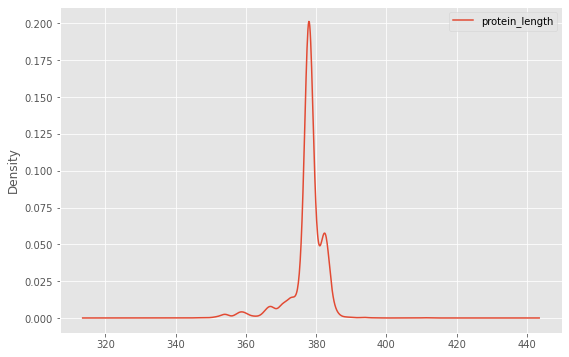

In [8]:
data_table_df.plot(kind='kde', y='protein_length', figsize=(9,6))


### Report Sequences that are too short or too long

In [9]:
#identify sequences outside of length range for analsysis
wronglength = data_table_df.loc[(data_table_df['protein_length'] < 350) | (data_table_df['protein_length'] > 390)]
wronglength

,gene_id,scientific_name,tax_id,genomic_range,orientation,location,protein_accession,protein_length,protein_name
gene_symbol,,,,,,,,,
CYTB,14412034,Polycheles typhlops,512014,NC_020026.1:13220-14404,+,chr MT,YP_007317402.1,394.0,cytochrome b
CYTB,16488854,Appalachioria falcifera,382869,NC_021933.1:13095-14279,+,chr MT,YP_008378738.1,394.0,cytochrome b
CYTB,19909943,Xenophyes cascus,984453,NC_024622.1:4092-5285,-,chr MT,YP_009049549.1,397.0,cytochrome b
CYTB,22158292,Pirata subpiraticus,330951,NC_025523.1:9589-10635,+,chr MT,YP_009104758.1,348.0,cytochrome b
CYTB,22832667,Lethe dura,1457180,NC_026062.1:10410-11585,+,chr MT,YP_009114186.1,391.0,cytochrome b
CYTB,26044919,Megachile sculpturalis,1004196,NC_028017.1:10779-12014,+,chr MT,YP_009170668.1,411.0,cytochrome b
CYTB,26833526,Heterometrus longimanus,1719223,NC_029207.1:8705-9745,+,chr MT,YP_009228517.1,346.0,cytochrome b
CYTB,37543102,Hemigrapsus penicillatus,135467,NC_038202.1:13977-15158,+,chr MT,YP_009504027.1,393.0,cytochrome b


### Remove sequences that are too short or too long           

In [10]:
## filter out sequences that are either too long or too short

min_len = 349
max_len = 391

rightlength = data_table_df.loc[(data_table_df['protein_length'] > min_len) & (data_table_df['protein_length'] < max_len)]
rightlength.to_csv(data_table, sep='\t')
rightlength.head()
#acclist = rightlength['protein_accession']
rightlength.to_csv('taxmap', index=False, header=False, sep ='\t', columns=['protein_accession', 'tax_id'])
#print(acclist)

In [14]:
from Bio import SeqIO
sequences = [] 
#print(rejectlist_df['accession'])
for seq_record in SeqIO.parse("ncbi_dataset/data/protein.faa", "fasta"): 
    s = seq_record    
    if seq_record.id in rightlength['protein_accession'].tolist():
        sequences.append(s)
    else:
        print(seq_record.id)
SeqIO.write(sequences, "stripped.fsa", "fasta")  



YP_009049549.1
YP_009104758.1
YP_008378738.1
YP_007317402.1
YP_009504027.1
YP_009170668.1
YP_009228517.1
YP_009114186.1


2814

## SKIP THIS FOR NOW Extract sequences from specific taxonomic group(s) for further analysis

Analyzing all of the sequences using all-vs-all BLAST is time-consuming. In this step, we will group the sequences into broad taxonomic groups for further analysis. 

In [19]:
acclist_for_blast = 'acclist_for_blast.tsv'
taxids = !cut -f2 example_data/tax_nodes.tsv | head -n 2 | paste -s -d ','
print(taxids)


['6854,7215']


In [20]:
!python3 scripts/seqids_by_taxa.py --bdbag {bdbag} --taxids {taxids[0]} --output {acclist_for_blast} --email {email}
#!python3 scripts/seqids_by_taxa.py --bdbag {bdbag} --taxids 7215 --output {acclist_for_blast} --email {email}

Traceback (most recent call last):
  File "scripts/seqids_by_taxa.py", line 92, in <module>
    main()
  File "scripts/seqids_by_taxa.py", line 56, in main
    for protein in gene['proteins']:
KeyError: 'proteins'


## Run all-vs-all BLAST

In [21]:
#!scripts/blast_all.sh -b {bdbag} -a {acclist_for_blast} -t 6
os.system("makeblastdb -in stripped.fsa -parse_seqids -dbtype prot -taxid_map taxmap -out prot_blastdb")
os.system("blastp -db prot_blastdb -num_threads 6 -query stripped.fsa -outfmt '7 std qcovs staxid ssciname' -out blastout.tsv")
#os.system("blast_formatter -archive blastout.asn -outfmt '7 std staxid ssciname' -out blastout.tsv")
#os.system("blastp -db nr -num_threads 6 -query stripped.fsa -outfmt '7 std qcovs staxid ssciname' -out blastout.tsv")

0

acclist_for_blast.tsv


## Read BLAST tsv file, remove matches to self
This creates a master file of the blast output with the organism names and taxids
NOTE NaN values in the taxid and orgname are due to inconsistencies in the data formatting from data/data_table.tsv downloaded from datasets. Need to fix this

In [11]:
file_name_string = (r'blastout.tsv')
table_df = pd.read_csv(file_name_string,
                       sep='\t',
                       index_col=None,
                       low_memory=False,
                       usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],
                       header=None,
                       names=["queryseqid", "subjectseqid", "identity", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "Evalue", "bitscore", "qcoverage", "taxid", "orgname"])
table_df = table_df[~table_df['queryseqid'].str.contains("#")]
table_df['%identity'] = pd.to_numeric(table_df['identity'])
table_df['length'] = pd.to_numeric(table_df['length'])
table_df['qstart'] = pd.to_numeric(table_df['qstart'])
table_df['qend'] = pd.to_numeric(table_df['qend'])
table_df['sstart'] = pd.to_numeric(table_df['sstart'])
table_df['send'] = pd.to_numeric(table_df['send'])
table_df['qcoverage'] = pd.to_numeric(table_df['qcoverage'])
table_df
#strip .version if needed
#table_df['queryseqid'] = table_df['queryseqid'].astype(st
#table_df['queryseqid'] = table_df['queryseqid'].map(lambda x: str(x)[:-1])
table2_df = table_df.loc[(table_df['queryseqid']) != (table_df['subjectseqid'])]
table2_df.drop(['mismatch', 'gapopen', 'bitscore', '%identity'], axis=1, inplace=True)
table2_df

/home/mcveigh/.local/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,queryseqid,subjectseqid,identity,length,qstart,qend,sstart,send,Evalue,qcoverage,taxid,orgname
5,NP_008080.1,YP_009176739.1,100.000,378.0,1.0,378.0,1.0,378.0,0.0,100.0,30066.0,Anopheles merus
6,NP_008080.1,YP_009176635.1,100.000,378.0,1.0,378.0,1.0,378.0,0.0,100.0,7173.0,Anopheles arabiensis
8,NP_008080.1,YP_009176700.1,99.471,378.0,1.0,378.0,1.0,378.0,0.0,100.0,199890.0,Anopheles epiroticus
9,NP_008080.1,YP_009176726.1,99.735,378.0,1.0,378.0,1.0,378.0,0.0,100.0,34690.0,Anopheles melas
10,NP_008080.1,YP_009176674.1,99.471,378.0,1.0,378.0,1.0,378.0,0.0,100.0,1518534.0,Anopheles coluzzii
...,...,...,...,...,...,...,...,...,...,...,...,...
1421079,YP_004021889.1,YP_003735167.1,76.800,375.0,3.0,377.0,6.0,380.0,0.0,99.0,768146.0,Spilonota lechriaspis
1421080,YP_004021889.1,YP_009144704.1,77.045,379.0,1.0,377.0,2.0,380.0,0.0,99.0,1454237.0,Hasora anura
1421081,YP_004021889.1,YP_009441719.1,75.871,373.0,5.0,377.0,1.0,373.0,0.0,99.0,107775.0,Amphizoa insolens
1421082,YP_004021889.1,YP_009539548.1,79.255,376.0,1.0,376.0,1.0,375.0,0.0,99.0,36976.0,Periplaneta brunnea


## Create a smaller dataframe with just numberical values

In [12]:
dftidy = table2_df.drop(['taxid', 'orgname'], axis=1)
dftidy

,queryseqid,subjectseqid,identity,length,qstart,qend,sstart,send,Evalue,qcoverage
5,NP_008080.1,YP_009176739.1,100.000,378.0,1.0,378.0,1.0,378.0,0.0,100.0
6,NP_008080.1,YP_009176635.1,100.000,378.0,1.0,378.0,1.0,378.0,0.0,100.0
8,NP_008080.1,YP_009176700.1,99.471,378.0,1.0,378.0,1.0,378.0,0.0,100.0
9,NP_008080.1,YP_009176726.1,99.735,378.0,1.0,378.0,1.0,378.0,0.0,100.0
10,NP_008080.1,YP_009176674.1,99.471,378.0,1.0,378.0,1.0,378.0,0.0,100.0
...,...,...,...,...,...,...,...,...,...,...
1421079,YP_004021889.1,YP_003735167.1,76.800,375.0,3.0,377.0,6.0,380.0,0.0,99.0
1421080,YP_004021889.1,YP_009144704.1,77.045,379.0,1.0,377.0,2.0,380.0,0.0,99.0
1421081,YP_004021889.1,YP_009441719.1,75.871,373.0,5.0,377.0,1.0,373.0,0.0,99.0
1421082,YP_004021889.1,YP_009539548.1,79.255,376.0,1.0,376.0,1.0,375.0,0.0,99.0


## Groupby and Aggregate the top ten rows of blast results

In [13]:
table3_df = dftidy.groupby('queryseqid').head(10) 
ident_group = table3_df.groupby('queryseqid').agg(['median', 'min', 'max']) 
ident_group

identity                  length               qstart            \
              median     min      max median    min    max median  min  max   
queryseqid                                                                    
NP_006913.1  96.4285  91.534   99.735  378.0  378.0  378.0    1.0  1.0  1.0   
NP_007119.1  77.2610  72.872   92.819  376.0  373.0  376.0    6.0  6.0  9.0   
NP_007301.1  92.5930  91.293   99.208  378.0  378.0  379.0    1.0  1.0  1.0   
NP_008080.1  99.4710  98.677  100.000  378.0  378.0  378.0    1.0  1.0  1.0   
NP_008093.1  91.3155  69.737   99.217  380.0  379.0  383.0    1.0  1.0  1.0   
...              ...     ...      ...    ...    ...    ...    ...  ...  ...   
YP_961309.1  90.2370  89.182   92.084  379.0  379.0  379.0    1.0  1.0  1.0   
YP_961393.1  99.6030  98.148  100.000  378.0  378.0  378.0    1.0  1.0  1.0   
YP_973126.1  91.0050  86.508   98.677  378.0  378.0  378.0    1.0  1.0  1.0   
YP_973139.1  87.5660  87.037   88.095  378.0  378.0  378.0    1.0  1.0  1.0   
YP_973152.1  89.1530  88.889   96.032  378.0  378.0  378.0    1.0  1.0  1.0   

              qend  ... sstart   send               Evalue            \
            median  ...    max median    min    max median  min  max   
queryseqid          ...                                                
NP_006913.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
NP_007119.1  381.0  ...    5.0  376.0  376.0  377.0    0.0  0.0  0.0   
NP_007301.1  378.0  ...    1.0  378.0  378.0  379.0    0.0  0.0  0.0   
NP_008080.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
NP_008093.1  380.0  ...    1.0  380.0  379.0  383.0    0.0  0.0  0.0   
...            ...  ...    ...    ...    ...    ...    ...  ...  ...   
YP_961309.1  379.0  ...    1.0  379.0  379.0  379.0    0.0  0.0  0.0   
YP_961393.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
YP_973126.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
YP_973139.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
YP_973152.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   

            qcoverage                
               median    min    max  
queryseqid                           
NP_006913.1     100.0  100.0  100.0  
NP_007119.1      99.0   98.0   99.0  
NP_007301.1      99.0   99.0  100.0  
NP_008080.1     100.0  100.0  100.0  
NP_008093.1      99.0   99.0  100.0  
...               ...    ...    ...  
YP_961309.1     100.0  100.0  100.0  
YP_961393.1     100.0  100.0  100.0  
YP_973126.1     100.0  100.0  100.0  
YP_973139.1     100.0  100.0  100.0  
YP_973152.1     100.0  100.0  100.0  

[2814 rows x 24 columns]

## Convert back to one dimentional index for searborn

In [14]:
ident_group.columns = ident_group.columns.map('_'.join)
ident_group.columns.get_level_values(0)


Index(['identity_median', 'identity_min', 'identity_max', 'length_median',
       'length_min', 'length_max', 'qstart_median', 'qstart_min', 'qstart_max',
       'qend_median', 'qend_min', 'qend_max', 'sstart_median', 'sstart_min',
       'sstart_max', 'send_median', 'send_min', 'send_max', 'Evalue_median',
       'Evalue_min', 'Evalue_max', 'qcoverage_median', 'qcoverage_min',
       'qcoverage_max'],
      dtype='object')

In [56]:
ident_group

,identity_mean,identity_min,identity_max,length_mean,length_min,length_max,qstart_mean,qstart_min,qstart_max,qend_mean,...,sstart_max,send_mean,send_min,send_max,Evalue_mean,Evalue_min,Evalue_max,qcoverage_mean,qcoverage_min,qcoverage_max
queryseqid,,,,,,,,,,,,,,,,,,,,,
NP_006913.1,95.8464,91.534,99.735,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,1.0,378.0,378.0,378.0,0.0,0.0,0.0,100.0,100.0,100.0
NP_007119.1,80.3776,72.872,92.819,375.7,373.0,376.0,6.3,6.0,9.0,381.0,...,5.0,376.2,376.0,377.0,0.0,0.0,0.0,98.9,98.0,99.0
NP_007301.1,93.8939,91.293,99.208,378.4,378.0,379.0,1.0,1.0,1.0,378.4,...,1.0,378.4,378.0,379.0,0.0,0.0,0.0,99.4,99.0,100.0
NP_008080.1,99.4443,98.677,100.000,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,1.0,378.0,378.0,378.0,0.0,0.0,0.0,100.0,100.0,100.0
NP_008093.1,90.3904,69.737,99.217,380.4,379.0,383.0,1.0,1.0,1.0,380.3,...,1.0,380.4,379.0,383.0,0.0,0.0,0.0,99.2,99.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YP_961309.1,90.3429,89.182,92.084,379.0,379.0,379.0,1.0,1.0,1.0,379.0,...,1.0,379.0,379.0,379.0,0.0,0.0,0.0,100.0,100.0,100.0
YP_961393.1,99.2855,98.148,100.000,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,1.0,378.0,378.0,378.0,0.0,0.0,0.0,100.0,100.0,100.0
YP_973126.1,92.0633,86.508,98.677,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,1.0,378.0,378.0,378.0,0.0,0.0,0.0,100.0,100.0,100.0


In [18]:
ident_group.to_csv(r'ident_group_file', sep ='\t', index = True)

## Let's plot the query coverage data to visual

<AxesSubplot:ylabel='Density'>

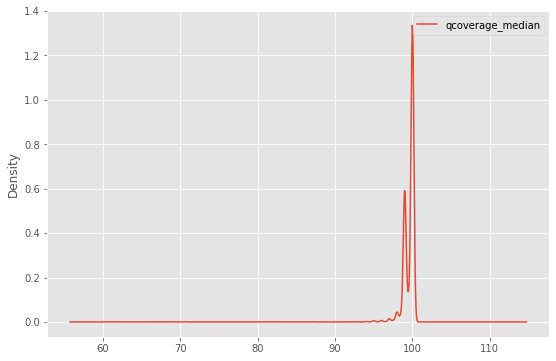

In [19]:
ident_group.plot(kind='kde', y='qcoverage_median', figsize=(9,6))
#dent_group.savefig('qcov_median.png')

## Median %identity

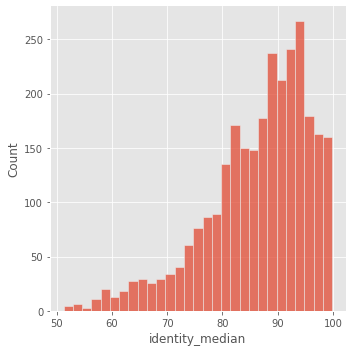

<Figure size 432x288 with 0 Axes>

In [20]:
sns.displot(ident_group.identity_median.dropna())
plt.show()
plt.savefig('identity_displot.png')

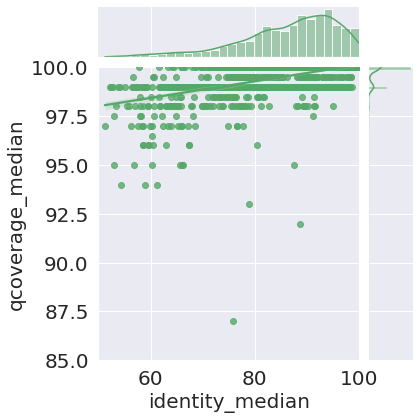

In [21]:
sns.set(rc={'axes.labelsize':20,
            'figure.figsize':(50.0, 20.0),
            'xtick.labelsize':20,
            'ytick.labelsize':20})
sns.jointplot(data=ident_group, x='identity_median', y='qcoverage_median', kind='reg', color='g', xlim=(50,100), ylim=(85,100))
plt.show()

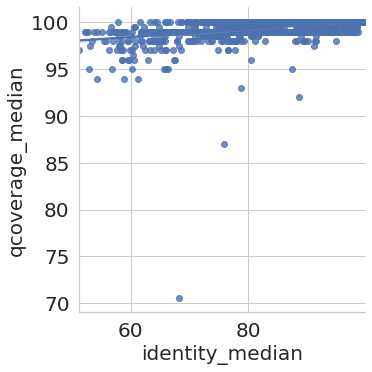

In [30]:
sns.set_style('whitegrid') 
sns.lmplot(x ='identity_median', y ='qcoverage_median', data = ident_group) 

## Identify sequences with values below the pass/fail thresholds %identity and query coverage

In [22]:
identity_low = ident_group[ident_group['identity_max'] <60 ].index.tolist()
identity_low

['YP_002317256.1',
 'YP_002317282.1',
 'YP_004841759.1',
 'YP_005087986.1',
 'YP_006234167.1',
 'YP_007026944.1',
 'YP_009020947.1',
 'YP_009126970.1',
 'YP_009544446.1',
 'YP_009710888.1',
 'YP_009945362.1']

In [23]:
qcov_low = ident_group[ident_group['qcoverage_min'] < 90].index.tolist()
qcov_low 

['YP_001218728.1',
 'YP_002836178.1',
 'YP_007025136.1',
 'YP_009306447.1',
 'YP_009945379.1',
 'YP_271856.1']

## Sort fasta file creating two files [1] seqs that pass [2] seqs that fail

In [24]:
from Bio import SeqIO
sequences = [] 
fail_sequence = []
for seq_record in SeqIO.parse("stripped.fsa", "fasta"):
    s = seq_record
    if seq_record.id in identity_low:
        #fail_sequence.append(s)
        print("fails seq identity test", seq_record.id)
        fail_sequence.append(s)
    if seq_record.id in qcov_low:
        fail_sequence.append(s)
        print("fails qcov test",seq_record.id)
    else:
        sequences.append(s)
        print(seq_record.id)
        
SeqIO.write(sequences, "outputfile", "fasta")

NP_008080.1
NP_872452.1
YP_009047277.1
NP_957753.1
NP_996550.1
YP_026063.1
YP_026102.1
YP_054494.1
YP_063384.1
YP_086825.1
YP_087052.1
YP_086810.1
YP_192899.1
YP_214899.1
YP_220586.1
YP_232823.1
YP_238266.1
YP_254681.1
YP_588094.1
YP_637125.1
YP_665523.1
YP_665536.1
YP_001023780.1
YP_001095994.1
YP_001096005.1
YP_001315043.1
YP_001382118.1
YP_001425550.1
YP_001427353.1
YP_001491569.1
YP_001542589.1
YP_001542727.1
YP_001552163.1
YP_001650760.1
YP_001789013.1
YP_001795379.1
YP_001798478.1
YP_001853761.1
YP_001974642.1
YP_001974577.1
YP_001974616.1
YP_002117917.1
YP_002117904.1
YP_002122323.1
YP_002213688.1
YP_002242164.1
YP_002274313.1
YP_002302555.1
YP_002456254.1
YP_002587084.1
YP_002650718.1
YP_002808600.1
YP_002808481.1
fails qcov test YP_002836178.1
YP_002889407.1
YP_002916052.1
YP_002922071.1
YP_002922058.1
YP_002929359.1
NP_075459.1
NP_085093.1
NP_112432.1
NP_150612.1
NP_203166.1
NP_563594.1
NP_570622.1
NP_652750.1
NP_694530.1
NP_775076.1
NP_722573.1
NP_803448.1
NP_006913.1
NP_008

YP_009434136.1
YP_009434149.1
YP_009443846.1
YP_009443859.1
YP_009443872.1
YP_009443885.1
YP_009443898.1
YP_009443911.1
YP_009443924.1
YP_009473425.1
YP_009473438.1
YP_009473477.1
YP_009473451.1
YP_009473464.1
YP_009515501.1
YP_009516293.1
YP_009516306.1
YP_009590056.1
YP_009590069.1
YP_009590082.1
YP_009590095.1
YP_009590108.1
YP_009590121.1
YP_009590134.1
YP_009918065.1
YP_009918078.1
YP_009918091.1
YP_009918104.1
YP_009918117.1
YP_009918130.1
YP_009919162.1
YP_009919135.1
YP_009919148.1
YP_009919166.1
YP_009919187.1
YP_009919200.1
YP_001798465.1
YP_001798517.1
YP_001936235.1
YP_001936656.1
YP_002261337.1
YP_002265547.1
YP_002265599.1
YP_003331014.1
YP_003331300.1
YP_003331326.1
YP_003331378.1
YP_004021616.1
YP_004934816.1
YP_004934842.1
YP_004934868.1
YP_004934907.1
YP_004935216.1
YP_006504024.1
YP_006504037.1
YP_006504050.1
YP_007024824.1
YP_007026236.1
YP_007026249.1
YP_007026262.1
YP_007026275.1
YP_007026288.1
YP_007026301.1
YP_007026314.1
YP_007026327.1
YP_007026340.1
YP_0070263

YP_009519717.1
YP_009519719.1
YP_009519881.1
YP_009520482.1
YP_009521631.1
YP_009522706.1
YP_009524086.1
YP_009524402.1
YP_009525299.1
YP_009525750.1
YP_009525763.1
YP_009525776.1
YP_009525790.1
YP_009525984.1
YP_009535653.1
YP_009528680.1
YP_009528694.1
YP_009528963.1
YP_009529012.1
YP_009529028.1
YP_009529041.1
YP_009529054.1
YP_009532690.1
YP_009532704.1
YP_009532921.1
YP_009532934.1
YP_009532947.1
YP_009535759.1
YP_009536180.1
YP_009536193.1
YP_009536829.1
YP_009536842.1
YP_009537179.1
YP_009526280.1
YP_009526498.1
YP_009526513.1
YP_009526864.1
YP_009527981.1
YP_009526489.1
YP_009539548.1
YP_009539640.1
YP_009539797.1
YP_009539810.1
YP_009540709.1
YP_009540722.1
YP_009540735.1
YP_009540822.1
YP_009542015.1
YP_009542273.1
YP_009542298.1
YP_009544113.1
YP_009544126.1
YP_009544458.1
YP_009545525.1
YP_009545539.1
YP_009551282.1
YP_009554106.1
YP_009554119.1
YP_009554232.1
YP_009554245.1
YP_009554258.1
YP_009555382.1
YP_009555985.1
YP_009558773.1
YP_009558786.1
YP_009560219.1
YP_0095602

2808

In [25]:
fh = open("outputfile")
n = 0
for line in fh:
    if line.startswith(">"):
        n += 1
fh.close()
print("Number of sequences passing blast filter and saved to outputfile:", n)

Number of sequences passing blast filter and saved to outputfile: 2808
